In [1]:
#mount drive to ur notebook since the images that we download will need more space
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install kaggle
!mkdir ~/.kaggle
!cp /content/drive/MyDrive/AI_Project/kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [3]:
#!kaggle datasets download -d nitinsss/fashion-dataset-with-over-15000-labelled-images
!kaggle datasets download -d nitinsss/fashion-dataset-with-over-15000-labelled-images -p /content/drive/MyDrive/AI_Project

fashion-dataset-with-over-15000-labelled-images.zip: Skipping, found more recently modified local copy (use --force to force download)


In [ ]:
!ls

drive  sample_data


In [4]:
#!unzip fashion-dataset-with-over-15000-labelled-images.zip
!unzip /content/drive/MyDrive/AI_Project/fashion-dataset-with-over-15000-labelled-images.zip -d /content/drive/MyDrive/AI_Project
!ls /content/drive/MyDrive/AI_Project

Archive:  /content/drive/MyDrive/AI_Project/fashion-dataset-with-over-15000-labelled-images.zip
replace /content/drive/MyDrive/AI_Project/dress.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: yes
  inflating: /content/drive/MyDrive/AI_Project/dress.csv  
dress.csv  fashion-dataset-with-over-15000-labelled-images.zip	images_tuned.zip  kaggle.json


In [5]:
import pandas as pd

df = pd.read_csv('/content/drive/MyDrive/AI_Project/dress.csv',on_bad_lines='skip')

In [6]:
df.shape

(15702, 4)

In [7]:
df.head
df.columns

Index(['_unit_id', 'category', 'category:confidence', 'image_url'], dtype='object')

In [8]:
df['category'].unique()

array(['ikat', 'plain', 'polka dot', 'geometry', 'floral', 'squares',
       'scales', 'animal', 'OTHER', 'stripes', 'tribal', 'houndstooth',
       'cartoon', 'chevron', 'stars', 'letter_numb', 'skull'],
      dtype=object)

In [9]:
df['category'].nunique()


17

In [10]:
df= df[(df['category']!='skull')&(df['category']!='stars')&(df['category']!='houndstooth')&(df['category']!='letter_numb')&(df['category']!='chevron')]
df.shape

(15394, 4)

In [11]:
# Filter the DataFrame to get rows corresponding to the specific category
category_rows = df[df['category'] == 'plain']  # Replace 'category_column' with the actual column name

# Randomly select a subset of rows to remove (e.g., 20%)
remove_fraction = 0.35  # Adjust as needed
num_rows_to_remove = int(len(category_rows) * remove_fraction)
rows_to_remove = category_rows.sample(n=num_rows_to_remove, random_state=42)

# Drop the selected rows from the DataFrame
df = df.drop(rows_to_remove.index)

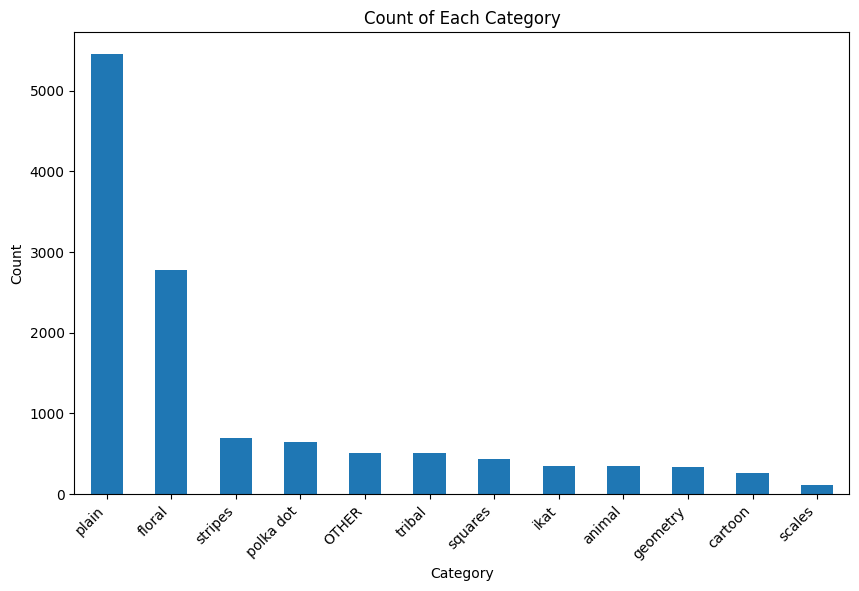

(12460, 4)

In [12]:
import matplotlib.pyplot as plt
category_counts = df['category'].value_counts()

plt.figure(figsize=(10, 6))
category_counts.plot(kind='bar')
plt.title('Count of Each Category')
plt.xlabel('Category')
plt.ylabel('Count')
plt.xticks(rotation=45, ha='right')
plt.show()
df.shape

In [ ]:
import shutil
import os
folder_path = 'temp2'

# Check if the folder exists before attempting to delete it
if os.path.exists(folder_path):
    # Use os.rmdir() to remove the directory
    shutil.rmtree(folder_path)
    print(f"Folder '{folder_path}' has been successfully deleted.")
else:
    print(f"Folder '{folder_path}' does not exist.")

Folder 'temp2' does not exist.


The below code is a one time activity to download the images from url and zip it and saved them.

In [ ]:
'''
import os
import requests
import numpy as np
import cv2
import zipfile
from io import BytesIO
from PIL import Image
from multiprocessing import Pool

def process_image(image_np):
    # Read the numpy arrays as color images in OpenCV
    image_bgr = cv2.imdecode(image_np, cv2.IMREAD_COLOR)

    # Convert to HSV for creating a mask
    image_hsv = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2HSV)

    # Create a mask that detects the red rectangular tags present in each image
    mask = cv2.inRange(image_hsv, (0, 255, 255), (0, 255, 255))

    # Get the coordinates of the red rectangle in the image,
    # But take entire image if mask fails to detect the red rectangle
    if len(np.where(mask != 0)[0]) != 0:
        y1 = min(np.where(mask != 0)[0])
        y2 = max(np.where(mask != 0)[0])
    else:
        y1 = 0
        y2 = len(mask)

    if len(np.where(mask != 0)[1]) != 0:
        x1 = min(np.where(mask != 0)[1])
        x2 = max(np.where(mask != 0)[1])
    else:
        x1 = 0
        x2 = len(mask[0])

    # Crop the image along those coordinates
    image_cropped = image_bgr[y1:y2, x1:x2]
    image_resized = cv2.resize(image_cropped, (96, 96))
    #image_rgb = cv2.cvtColor(image_resized, cv2.COLOR_BGR2RGB)
    image = Image.fromarray(image_resized)
    return image

def download_image_and_save(row):
    image_url = row['image_url']
    response = requests.get(image_url)

    if response.status_code == 200:
        image_np = np.asarray(bytearray(response.content), dtype=np.uint8)
        cropped_image = process_image(image_np)

        # Save the preprocessed image directly into the in-memory zip file
        image_bytes = BytesIO()
        cropped_image.save(image_bytes, format='JPEG')
        return image_bytes.getvalue(), f"{row['category']}/{row['_unit_id']}.jpg"
    else:
        print(f"Failed to download image from URL: {image_url}")
        return None, None

def download_images_in_batch(batch_df):
    images_to_zip = []
    with Pool(processes=os.cpu_count()) as pool:
        results = pool.map(download_image_and_save, [row for _, row in batch_df.iterrows()])

    for result in results:
        if result[0] is not None:
            image_bytes, zip_path = result
            images_to_zip.append((image_bytes, zip_path))

    return images_to_zip

# Define output zip file name
zip_filename = 'drive/MyDrive/images_tuned.zip'
batch_size = 100

# Create a zip file in-memory
i=1
with zipfile.ZipFile(zip_filename, 'w') as zipf:
    for batch_idx in range(0, len(df), batch_size):
        batch_df = df.iloc[batch_idx:batch_idx + batch_size]
        images_to_zip = download_images_in_batch(batch_df)
        print(f'batch{i}')
        i+=1
        for image_bytes, zip_path in images_to_zip:
            zipf.writestr(zip_path, image_bytes)

print("All images zipped successfully.")
'''

Unzip the downloaded images

In [13]:
import io
from torchvision.io import read_image
import zipfile

zip_path = '/content/drive/MyDrive/AI_Project/images_tuned.zip'

extracted_dir = 'temp3'

try:
    # Extract the zip file into the specified directory
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall(extracted_dir)
    print("Extraction successful.")
except Exception as e:
    print("Error occurred during extraction:", str(e))

Extraction successful.


In [ ]:
'''import os
from torchvision import transforms, datasets
from torchvision.datasets import ImageFolder
from collections import Counter
from PIL import Image
import random

# Define transformations for augmentation
def augmentation_transform(image):
   ''' ''' # Randomly apply color jitter
    if random.random() < 0.5:
        color_jitter = transforms.ColorJitter(brightness=0.5,contrast=0.5, saturation=0.5, hue=0.5)
        image = color_jitter(image)
    ''' '''
    # Randomly apply rotation
    if random.random() < 0.5:
        degrees = random.uniform(-45, 45)
        image = transforms.functional.rotate(image, degrees)

    # Randomly apply horizontal flip
    if random.random() < 0.5:
        image = transforms.functional.hflip(image)

    # Randomly apply vertical flip
    if random.random() < 0.5:
        image = transforms.functional.vflip(image)

    return image

# Define the maximum number of augmented samples per class
max_augmented_samples_per_image = 3

# Create dataset from the extracted folder
dataset = ImageFolder(extracted_dir)

# Count of each class
class_counts = Counter(dataset.targets)

# Define the classes that need augmentation
classes_to_augment = [cls for cls, count in class_counts.items() if count < 1000]
dataset_classes = dataset.classes

# Augment data for classes with counts less than 1000
for cls in classes_to_augment:
    class_samples = [(img_path, label) for img_path, label in dataset.imgs if label == cls]
    for img_path, label in class_samples:
        image = Image.open(img_path)
        augmented_samples_count = min(len(class_samples), max_augmented_samples_per_image)
        for i in range(augmented_samples_count):
            augmented_image = augmentation_transform(image)
            augmented_image.save(os.path.join(extracted_dir, f'{dataset_classes[label]}/{dataset_classes[label]}_{i+1}_{os.path.basename(img_path)}'))

print("Augmentation completed.")
'''

Augmentation completed.


In [16]:
from torchvision import transforms, datasets
from torchvision.datasets import DatasetFolder
from torchvision.datasets import ImageFolder
from collections import Counter
# Define transformations
transform = transforms.Compose([
    transforms.Resize((224,224)),
    #transforms.RandomHorizontalFlip(),
    #transforms.RandomVerticalFlip(),
    #transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])
# Create a new dataset from the augmented data

dataset = ImageFolder(extracted_dir,transform=transform)


In [17]:
from torchvision.datasets import DatasetFolder
from torch.utils.data import DataLoader, Dataset, random_split
import torch
import numpy as np
# Define the indices for train, validation, and test sets
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# Define the lengths of subsets (e.g., training, validation, and testing)
dataset_size = len(dataset)
train_size = int(0.8 * dataset_size)
val_size = int(0.1 * dataset_size)
test_size = dataset_size - train_size - val_size

# Use random_split to split the dataset into training, validation, and testing
train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])

print("Train",len(train_dataset))
print("Test",len(test_dataset))
print("Val",len(val_dataset))
# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32)
test_loader = DataLoader(test_dataset, batch_size=32)

print("Completed")

Train 9968
Test 1246
Val 1246
Completed


#VGG16 part


In [ ]:
import torchvision.models as models
import torch.nn as nn
from collections import Counter
import torch
# Define the model
#model = models.mobilenet_v2(pretrained=False)  # Using MobileNetV2
model = models.vgg16(pretrained=False)  # Using vgg16
#model = models.resnet18(pretrained=False)  # Using resnet18
num_features = model.classifier[-1].in_features
num_classes =  len(dataset.classes)
model.classifier[-1] = nn.Linear(num_features, num_classes)
model = model.to(device)
#print(model)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


In [ ]:
import torch.optim as optim
from torch.optim import lr_scheduler
# Loss and optimizer
criterion = nn.CrossEntropyLoss()
#criterion = nn.MultiLabelSoftMarginLoss()
#69.41%
#criterion = nn.MSELoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
#optimizer = optim.Adam(model.parameters(), lr=0.001)

In [ ]:
num_epochs=10

Epoch 1/10, Training Loss: 1.8282, Validation Loss: 1.7625, Train Accuracy: 43.90%, Validation Accuracy: 52.41%
Epoch 2/10, Training Loss: 1.6101, Validation Loss: 1.5670, Train Accuracy: 55.38%, Validation Accuracy: 56.34%
Epoch 3/10, Training Loss: 1.5390, Validation Loss: 1.5053, Train Accuracy: 57.72%, Validation Accuracy: 59.07%
Epoch 4/10, Training Loss: 1.4946, Validation Loss: 1.4518, Train Accuracy: 58.88%, Validation Accuracy: 59.55%
Epoch 5/10, Training Loss: 1.4703, Validation Loss: 1.4740, Train Accuracy: 59.62%, Validation Accuracy: 59.71%
Epoch 6/10, Training Loss: 1.4450, Validation Loss: 1.4301, Train Accuracy: 60.08%, Validation Accuracy: 61.24%
Epoch 7/10, Training Loss: 1.4317, Validation Loss: 1.4115, Train Accuracy: 60.66%, Validation Accuracy: 61.64%
Epoch 8/10, Training Loss: 1.4055, Validation Loss: 1.4269, Train Accuracy: 61.40%, Validation Accuracy: 61.00%
Epoch 9/10, Training Loss: 1.3979, Validation Loss: 1.4468, Train Accuracy: 61.97%, Validation Accuracy:

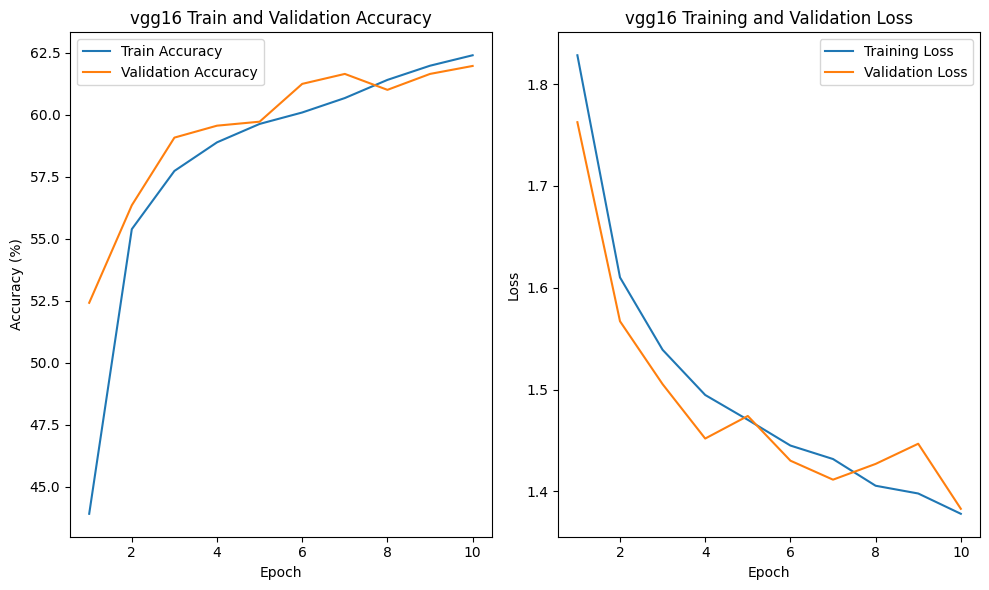

In [ ]:
import matplotlib.pyplot as plt
# Lists to store training and validation loss
train_losses = []
val_losses = []

# Lists to store validation accuracy
val_accuracies = []
train_accuracies= []
# Training loop
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    train_correct = 0
    train_total = 0
    for images, labels in train_loader:
        #print(type(images))
        images = images.to(device)
        labels=labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)

        # Convert labels to tensors
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * images.size(0)
        # Calculate train accuracy
        _, predicted = torch.max(outputs, 1)
        train_total += labels.size(0)
        train_correct += (predicted == labels).sum().item()

    train_loss = running_loss / len(train_loader.dataset)
    train_accuracy = (train_correct / train_total) * 100

    # Validation loop
    model.eval()
    val_loss = 0.0
    val_correct = 0
    val_total = 0
    with torch.no_grad():
        for images, labels in val_loader:
            images = images.to(device)
            outputs = model(images)
            labels=labels.to(device)

            # Convert labels to tensors
            loss = criterion(outputs, labels)
            val_loss += loss.item() * images.size(0)
            _, predicted = torch.max(outputs, 1)
            val_total += labels.size(0)
            val_correct += (predicted == labels).sum().item()

    val_loss = val_loss / len(val_loader.dataset)
    val_accuracy = (val_correct / val_total) * 100

    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_accuracies.append(train_accuracy)
    val_accuracies.append(val_accuracy)

    # Print statistics
    print(f'Epoch {epoch + 1}/{num_epochs}, '
          f'Training Loss: {train_loss:.4f}, '
          f'Validation Loss: {val_loss:.4f}, '
          f'Train Accuracy: {train_accuracy:.2f}%, '
          f'Validation Accuracy: {val_accuracy:.2f}%')

# Plotting subplots for accuracy and loss side by side
fig, axes = plt.subplots(1, 2, figsize=(10, 6))

# Plot train and validation accuracy
axes[0].plot(range(1, num_epochs + 1), train_accuracies, label='Train Accuracy')
axes[0].plot(range(1, num_epochs + 1), val_accuracies, label='Validation Accuracy')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Accuracy (%)')
axes[0].set_title('vgg16 Train and Validation Accuracy')
axes[0].legend()

# Plot train and validation loss
axes[1].plot(range(1, num_epochs + 1), train_losses, label='Training Loss')
axes[1].plot(range(1, num_epochs + 1), val_losses, label='Validation Loss')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Loss')
axes[1].set_title('vgg16 Training and Validation Loss')
axes[1].legend()

plt.tight_layout()  # Adjust subplot parameters to give specified padding
plt.show()

Test Accuracy: 61.88%


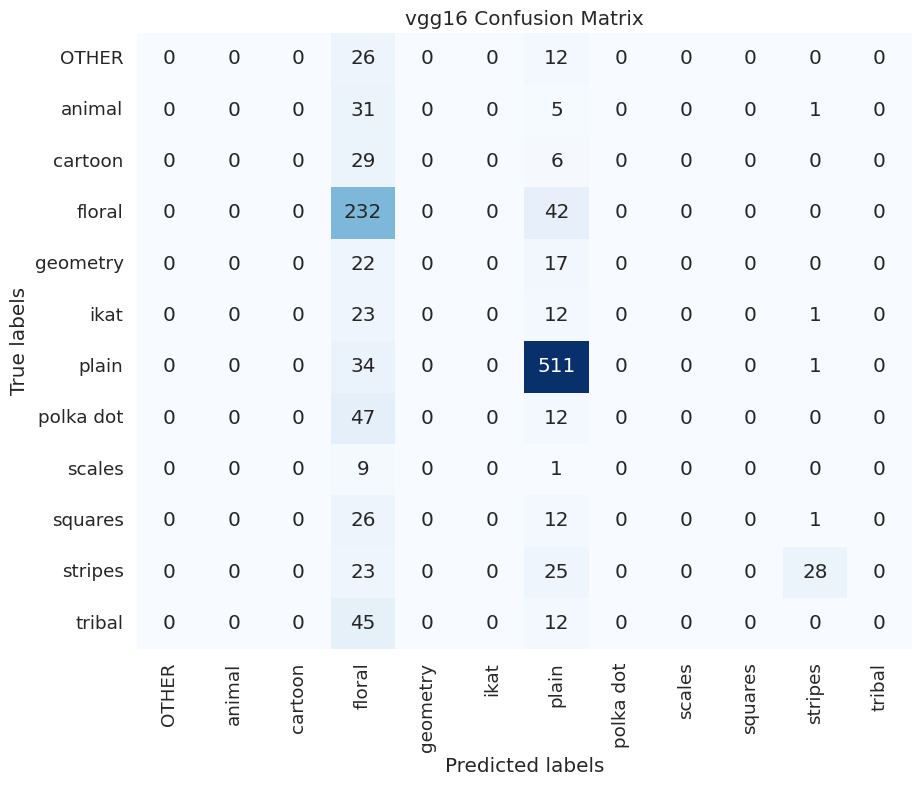

'# Create confusion matrix\nconf_matrix = confusion_matrix(true_labels, pred_labels)\n\n# Plot confusion matrix\nplt.figure(figsize=(10, 8))\nsns.set(font_scale=1.2)  # Adjust font scale for better readability\nsns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", cbar=False)\nplt.xlabel("Predicted Labels")\nplt.ylabel("True Labels")\nplt.title("Confusion Matrix")\nplt.show()\n'

In [ ]:
from sklearn.metrics import confusion_matrix,ConfusionMatrixDisplay

import numpy as np
import seaborn as sns
import pandas as pd
# Testing loop
model.eval()
test_correct = 0
test_total = 0
true_labels = []
pred_labels = []
with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        test_total += labels.size(0)
        test_correct += (predicted == labels).sum().item()
        true_labels.extend(labels.data.cpu().numpy())
        pred_labels.extend(predicted.data.cpu().numpy())


print(f'Test Accuracy: {(test_correct/test_total)*100:.2f}%')

# Calculate confusion matrix
conf_matrix = confusion_matrix(true_labels, pred_labels)
class_names=dataset.classes

# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.set(font_scale=1.2)  # Adjust font scale for better visualization
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('vgg16 Confusion Matrix')
plt.show()

'''# Plot confusion matrix
plt.figure(figsize=(10, 8))
plt.imshow(conf_matrix, interpolation='nearest', cmap=plt.cm.Greys)
plt.title('mobilenet_v2_Confusion Matrix')
plt.colorbar()
classes = dataset.classes  # Assuming dataset is defined
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation=45)
plt.yticks(tick_marks, classes)

thresh = conf_matrix.max() / 2
for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        plt.text(j, i, format(conf_matrix[i, j], 'd'),
                 horizontalalignment="center",
                 color="white" if conf_matrix[i, j] > thresh else "black")

plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()'''

'''# Build confusion matrix
classes = dataset.classes  # Assuming dataset is defined
cf_matrix = confusion_matrix(true_labels, pred_labels)
df_cm = pd.DataFrame(cf_matrix , index = [i for i in classes],
                     columns = [i for i in classes])
plt.figure(figsize = (12,7))
sns.heatmap(df_cm, annot=True)'''


'''# Create confusion matrix
conf_matrix = confusion_matrix(true_labels, pred_labels)

# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.set(font_scale=1.2)  # Adjust font scale for better readability
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")
plt.show()
'''

#Resnet 18 part

In [ ]:
import torchvision.models as models
import torch.nn as nn
from collections import Counter
import torch
# Define the model
model = models.resnet18(pretrained=False)  # Using resnet18
# Get the number of input features to the last fully connected layer
num_features = model.fc.in_features

# Assuming num_classes is the number of classes in your dataset
num_classes = len(dataset.classes)

# Replace the last fully connected layer (classifier) with a new one
model.fc = nn.Linear(num_features, num_classes)
model = model.to(device)
#print(model)

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
#criterion = nn.MultiLabelSoftMarginLoss()
#69.41%
#criterion = nn.MSELoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
#optimizer = optim.Adam(model.parameters(), lr=0.001)

num_epochs=10

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


Epoch 1/10, Training Loss: 1.6415, Validation Loss: 1.6314, Train Accuracy: 52.93%, Validation Accuracy: 57.62%
Epoch 2/10, Training Loss: 1.4843, Validation Loss: 1.4452, Train Accuracy: 59.03%, Validation Accuracy: 60.03%
Epoch 3/10, Training Loss: 1.4288, Validation Loss: 1.4142, Train Accuracy: 60.70%, Validation Accuracy: 61.80%
Epoch 4/10, Training Loss: 1.3843, Validation Loss: 1.3412, Train Accuracy: 61.89%, Validation Accuracy: 62.92%
Epoch 5/10, Training Loss: 1.3420, Validation Loss: 1.4049, Train Accuracy: 62.65%, Validation Accuracy: 61.80%
Epoch 6/10, Training Loss: 1.2949, Validation Loss: 1.3408, Train Accuracy: 63.69%, Validation Accuracy: 62.92%
Epoch 7/10, Training Loss: 1.2677, Validation Loss: 1.3367, Train Accuracy: 64.17%, Validation Accuracy: 63.16%
Epoch 8/10, Training Loss: 1.2333, Validation Loss: 1.3928, Train Accuracy: 64.90%, Validation Accuracy: 61.96%
Epoch 9/10, Training Loss: 1.1782, Validation Loss: 1.4068, Train Accuracy: 66.56%, Validation Accuracy:

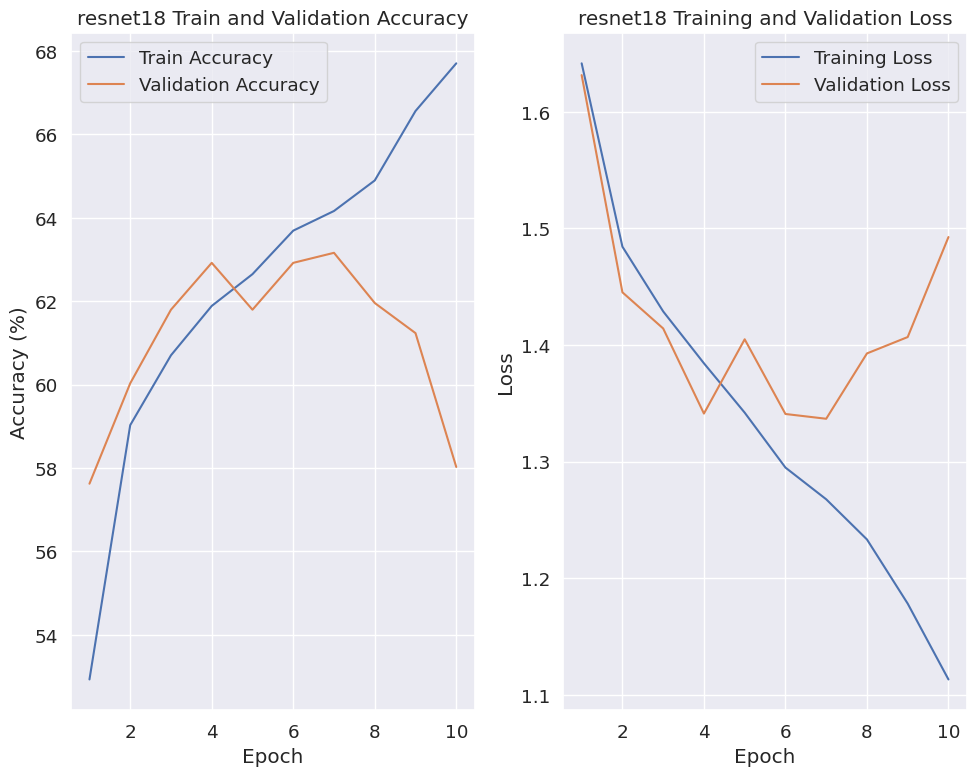

In [ ]:
# Lists to store training and validation loss
train_losses = []
val_losses = []

# Lists to store validation accuracy
val_accuracies = []
train_accuracies= []
# Training loop
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    train_correct = 0
    train_total = 0
    for images, labels in train_loader:
        #print(type(images))
        images = images.to(device)
        labels=labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)

        # Convert labels to tensors
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * images.size(0)
        # Calculate train accuracy
        _, predicted = torch.max(outputs, 1)
        train_total += labels.size(0)
        train_correct += (predicted == labels).sum().item()

    train_loss = running_loss / len(train_loader.dataset)
    train_accuracy = (train_correct / train_total) * 100

    # Validation loop
    model.eval()
    val_loss = 0.0
    val_correct = 0
    val_total = 0
    with torch.no_grad():
        for images, labels in val_loader:
            images = images.to(device)
            outputs = model(images)
            labels=labels.to(device)

            # Convert labels to tensors
            loss = criterion(outputs, labels)
            val_loss += loss.item() * images.size(0)
            _, predicted = torch.max(outputs, 1)
            val_total += labels.size(0)
            val_correct += (predicted == labels).sum().item()

    val_loss = val_loss / len(val_loader.dataset)
    val_accuracy = (val_correct / val_total) * 100

    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_accuracies.append(train_accuracy)
    val_accuracies.append(val_accuracy)

    # Print statistics
    print(f'Epoch {epoch + 1}/{num_epochs}, '
          f'Training Loss: {train_loss:.4f}, '
          f'Validation Loss: {val_loss:.4f}, '
          f'Train Accuracy: {train_accuracy:.2f}%, '
          f'Validation Accuracy: {val_accuracy:.2f}%')

# Plotting subplots for accuracy and loss side by side
fig, axes = plt.subplots(1, 2, figsize=(10, 8))

# Plot train and validation accuracy
axes[0].plot(range(1, num_epochs + 1), train_accuracies, label='Train Accuracy')
axes[0].plot(range(1, num_epochs + 1), val_accuracies, label='Validation Accuracy')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Accuracy (%)')
axes[0].set_title('resnet18 Train and Validation Accuracy')
axes[0].legend()

# Plot train and validation loss
axes[1].plot(range(1, num_epochs + 1), train_losses, label='Training Loss')
axes[1].plot(range(1, num_epochs + 1), val_losses, label='Validation Loss')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Loss')
axes[1].set_title('resnet18 Training and Validation Loss')
axes[1].legend()

plt.tight_layout()  # Adjust subplot parameters to give specified padding
plt.show()

Test Accuracy: 58.27%


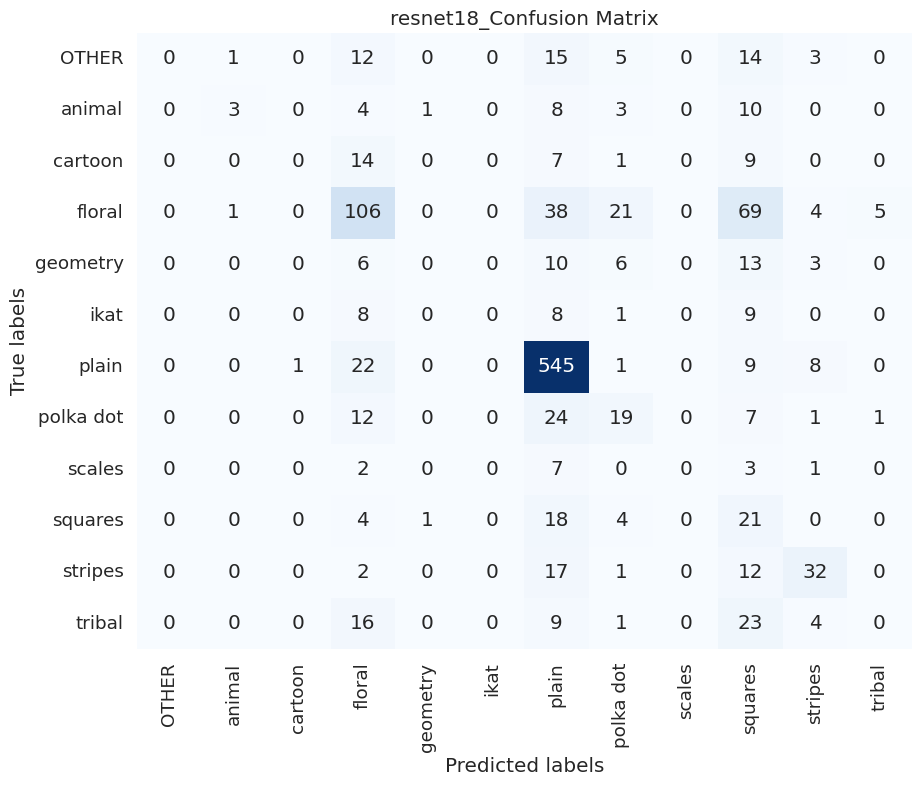

In [ ]:
model.eval()
test_correct = 0
test_total = 0
true_labels = []
pred_labels = []
with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        test_total += labels.size(0)
        test_correct += (predicted == labels).sum().item()
        true_labels.extend(labels.data.cpu().numpy())
        pred_labels.extend(predicted.data.cpu().numpy())


print(f'Test Accuracy: {(test_correct/test_total)*100:.2f}%')

# Calculate confusion matrix
conf_matrix = confusion_matrix(true_labels, pred_labels)
class_names=dataset.classes

# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.set(font_scale=1.2)  # Adjust font scale for better visualization
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('resnet18_Confusion Matrix')
plt.show()

#MobileNetV2

In [18]:
import torchvision.models as models
import torch.nn as nn
from collections import Counter
import torch
# Define the model
model = models.mobilenet_v2(pretrained=False)  # Using MobileNetV2
num_features = model.classifier[-1].in_features
num_classes =  len(dataset.classes)
model.classifier[-1] = nn.Linear(num_features, num_classes)
model = model.to(device)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


In [19]:
import torch.optim as optim
from torch.optim import lr_scheduler
# Loss and optimizer
criterion = nn.CrossEntropyLoss()
#criterion = nn.MultiLabelSoftMarginLoss()
#69.41%
#criterion = nn.MSELoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
#optimizer = optim.Adam(model.parameters(), lr=0.001)

num_epochs=10

Epoch 1/10, Training Loss: 1.6507, Validation Loss: 1.5764, Train Accuracy: 52.65%, Validation Accuracy: 55.86%
Epoch 2/10, Training Loss: 1.5431, Validation Loss: 1.4947, Train Accuracy: 56.82%, Validation Accuracy: 58.03%
Epoch 3/10, Training Loss: 1.4998, Validation Loss: 1.4487, Train Accuracy: 58.50%, Validation Accuracy: 60.11%
Epoch 4/10, Training Loss: 1.4658, Validation Loss: 1.4497, Train Accuracy: 59.88%, Validation Accuracy: 60.27%
Epoch 5/10, Training Loss: 1.4418, Validation Loss: 1.4029, Train Accuracy: 60.41%, Validation Accuracy: 61.88%
Epoch 6/10, Training Loss: 1.4179, Validation Loss: 1.4126, Train Accuracy: 60.82%, Validation Accuracy: 61.72%
Epoch 7/10, Training Loss: 1.4047, Validation Loss: 1.3735, Train Accuracy: 61.59%, Validation Accuracy: 62.36%
Epoch 8/10, Training Loss: 1.3834, Validation Loss: 1.3653, Train Accuracy: 61.71%, Validation Accuracy: 62.52%
Epoch 9/10, Training Loss: 1.3791, Validation Loss: 1.3746, Train Accuracy: 61.82%, Validation Accuracy:

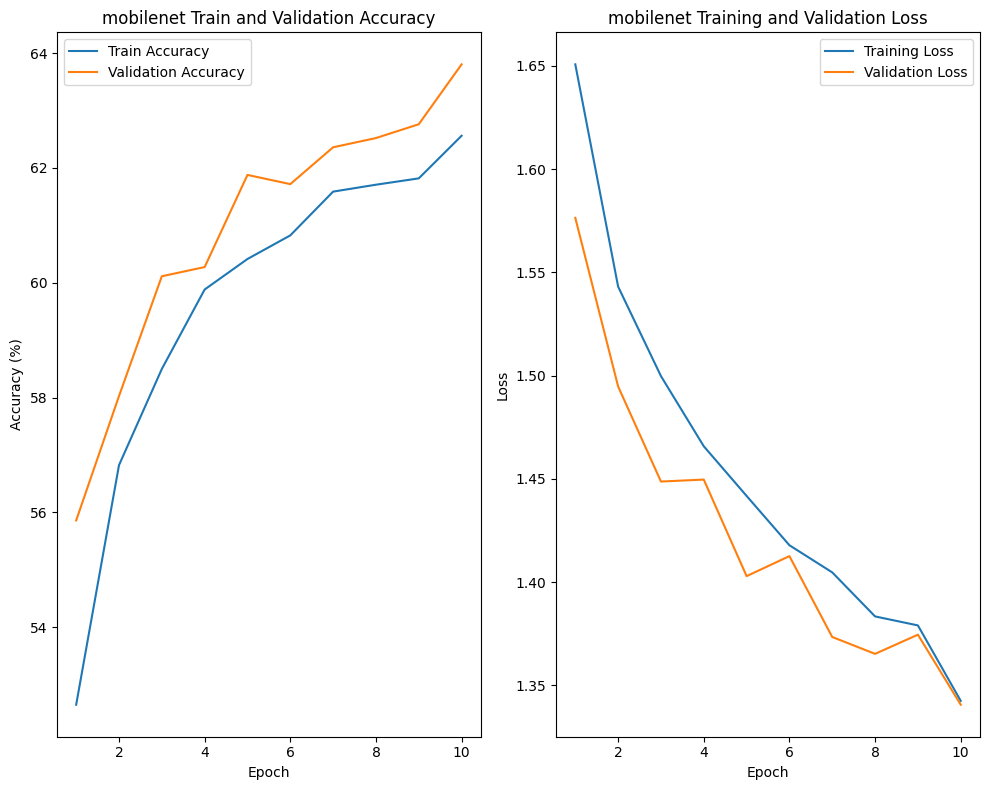

In [20]:
# Lists to store training and validation loss
train_losses = []
val_losses = []

# Lists to store validation accuracy
val_accuracies = []
train_accuracies= []
# Training loop
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    train_correct = 0
    train_total = 0
    for images, labels in train_loader:
        #print(type(images))
        images = images.to(device)
        labels=labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)

        # Convert labels to tensors
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * images.size(0)
        # Calculate train accuracy
        _, predicted = torch.max(outputs, 1)
        train_total += labels.size(0)
        train_correct += (predicted == labels).sum().item()

    train_loss = running_loss / len(train_loader.dataset)
    train_accuracy = (train_correct / train_total) * 100

    # Validation loop
    model.eval()
    val_loss = 0.0
    val_correct = 0
    val_total = 0
    with torch.no_grad():
        for images, labels in val_loader:
            images = images.to(device)
            outputs = model(images)
            labels=labels.to(device)

            # Convert labels to tensors
            loss = criterion(outputs, labels)
            val_loss += loss.item() * images.size(0)
            _, predicted = torch.max(outputs, 1)
            val_total += labels.size(0)
            val_correct += (predicted == labels).sum().item()

    val_loss = val_loss / len(val_loader.dataset)
    val_accuracy = (val_correct / val_total) * 100

    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_accuracies.append(train_accuracy)
    val_accuracies.append(val_accuracy)

    # Print statistics
    print(f'Epoch {epoch + 1}/{num_epochs}, '
          f'Training Loss: {train_loss:.4f}, '
          f'Validation Loss: {val_loss:.4f}, '
          f'Train Accuracy: {train_accuracy:.2f}%, '
          f'Validation Accuracy: {val_accuracy:.2f}%')

# Plotting subplots for accuracy and loss side by side
fig, axes = plt.subplots(1, 2, figsize=(10, 8))

# Plot train and validation accuracy
axes[0].plot(range(1, num_epochs + 1), train_accuracies, label='Train Accuracy')
axes[0].plot(range(1, num_epochs + 1), val_accuracies, label='Validation Accuracy')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Accuracy (%)')
axes[0].set_title('mobilenet Train and Validation Accuracy')
axes[0].legend()

# Plot train and validation loss
axes[1].plot(range(1, num_epochs + 1), train_losses, label='Training Loss')
axes[1].plot(range(1, num_epochs + 1), val_losses, label='Validation Loss')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Loss')
axes[1].set_title('mobilenet Training and Validation Loss')
axes[1].legend()

plt.tight_layout()  # Adjust subplot parameters to give specified padding
plt.show()

Test Accuracy: 60.83%


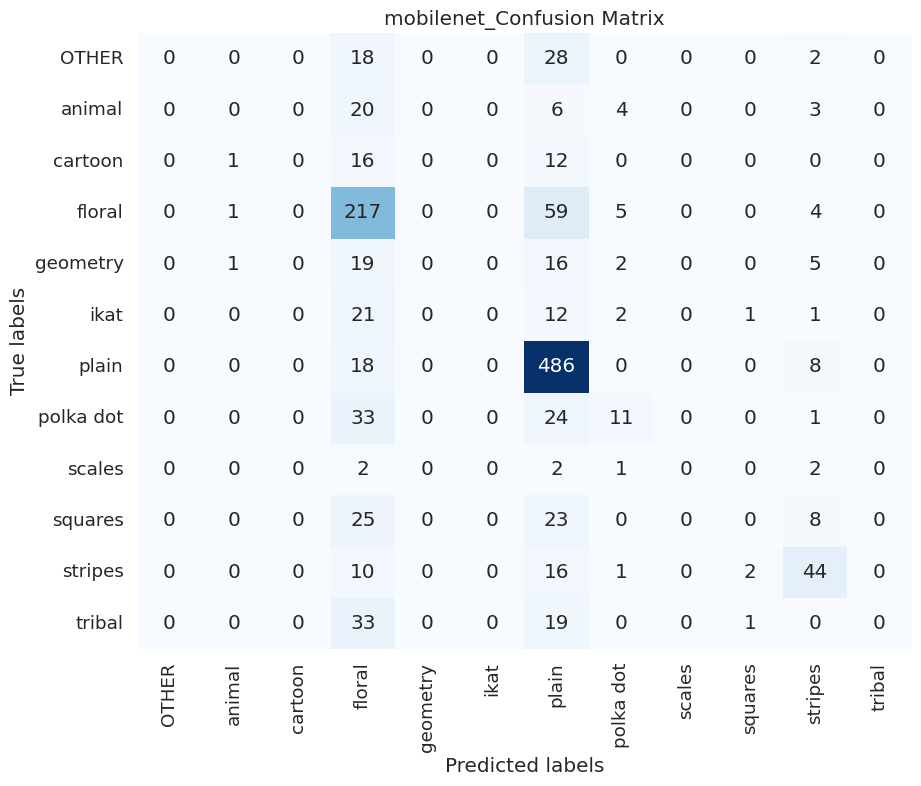

In [ ]:
from sklearn.metrics import confusion_matrix,ConfusionMatrixDisplay
import numpy as np
import seaborn as sns
import pandas as pd
model.eval()
test_correct = 0
test_total = 0
true_labels = []
pred_labels = []
with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        test_total += labels.size(0)
        test_correct += (predicted == labels).sum().item()
        true_labels.extend(labels.data.cpu().numpy())
        pred_labels.extend(predicted.data.cpu().numpy())


print(f'Test Accuracy: {(test_correct/test_total)*100:.2f}%')

# Calculate confusion matrix
conf_matrix = confusion_matrix(true_labels, pred_labels)
class_names=dataset.classes

# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.set(font_scale=1.2)  # Adjust font scale for better visualization
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('mobilenet_Confusion Matrix')
plt.show()